# SDSS Galaxies vs Quasars

Tasks
- Create arrays for the (u-g), (g-r), (r-i), (i-z) colors. Also create an array with the class labels where galaxy=0 and quasar=1.
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

In [ ]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroXtatistics\Notebooks\venv\Utilities")
import matplotlib.pyplot as plt 
import seaborn as sns
from Utilities import plot_settings
import numpy as np
import pandas as pd

In [2]:
data_path = r'C:\Users\ricca\OneDrive\Documents\Data\galaxyquasar.csv'
data = pd.read_csv(data_path)

In [ ]:
ug = (data['u'] - data['g']).to_numpy()
gr = (data['g'] - data['r']).to_numpy()
ri = (data['r'] - data['i']).to_numpy()
iz = (data['i'] - data['z']).to_numpy()

true_labels = np.where(data['class'].to_numpy() == 'QXO', 1, 0)

In [ ]:
X = np.vstack([ug, gr, ri, iz]).T
y = true_labels

Data exploration

In [ ]:
from matplotlib.lines import Line2D

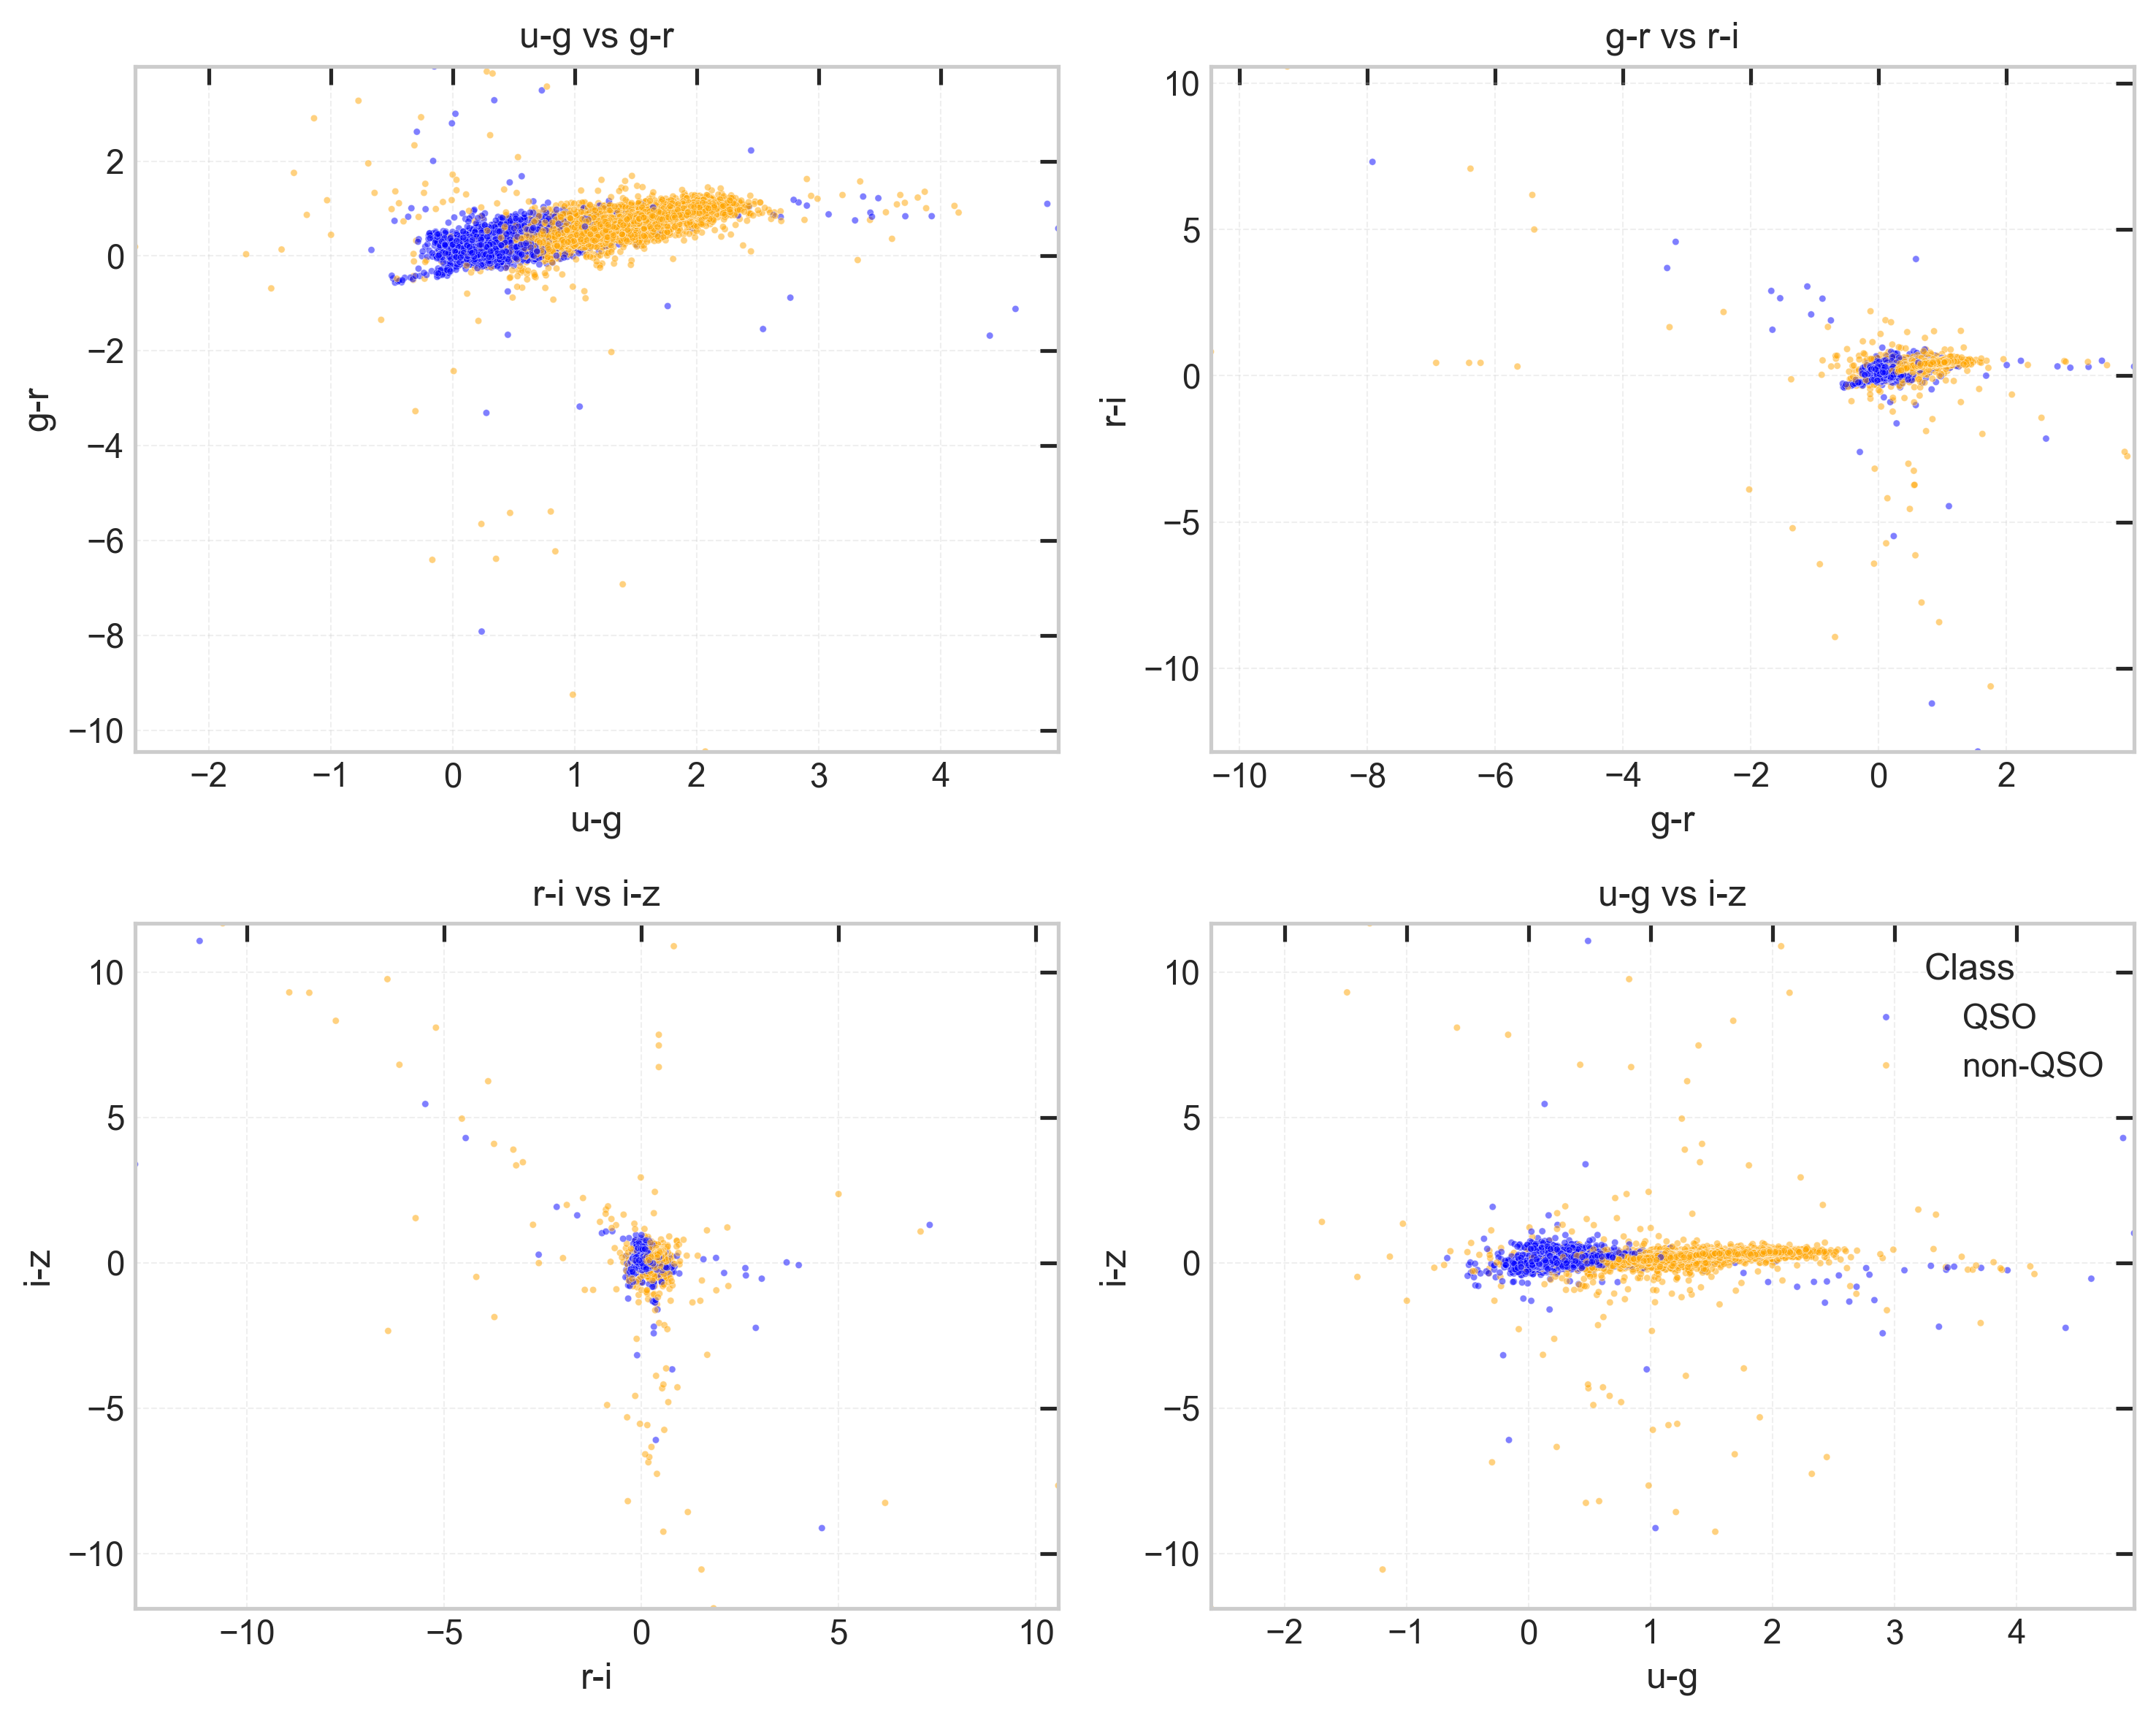

In [60]:
# Prepare dataframe for seaborn
df = pd.DataFrame(X, columns=['u-g', 'g-r', 'r-i', 'i-z'])
df['class'] = np.where(y == 1, 'QSO', 'non-QSO')

# Seaborn color palette
palette = {'non-QSO': 'orange', 'QSO': 'blue'}

# Plot setup
sns.set(style="whitegrid", rc={'figure.dpi': 300, 'savefig.dpi': 300})

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Define axes
sns.scatterplot(data=df, x='u-g', y='g-r', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 0], legend=False)
axs[0, 0].set_title('u-g vs g-r')

sns.scatterplot(data=df, x='g-r', y='r-i', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[0, 1], legend=False)
axs[0, 1].set_title('g-r vs r-i')

sns.scatterplot(data=df, x='r-i', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 0], legend=False)
axs[1, 0].set_title('r-i vs i-z')

sns.scatterplot(data=df, x='u-g', y='i-z', hue='class', palette=palette,
                s=5, alpha=0.5, ax=axs[1, 1])
axs[1, 1].set_title('u-g vs i-z')

# Shared formatting
for ax in axs.flat:
    ax.tick_params(direction='in', top=True, right=True)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.3)

# Clean legend (from bottom-right plot only)
handles, labels = axs[1, 1].get_legend_handles_labels()
axs[1, 1].legend(handles=handles, labels=labels, loc='upper right', title='Class')

plt.tight_layout()
plt.savefig("seaborn_color_color_qso_vs_nonqso.png", bbox_inches='tight')
plt.show()


## K-Nearest Neighbours Classification

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from astroML.utils import completeness_contamination
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score

In [16]:
scores = []
kvals = np.linspace(1,20,20, dtype=int)
for k in kvals:
    clf = KNeighborsClassifier(n_neighbors=k)
    CVpredk = cross_val_predict(clf, X, true_labels)
    scores.append(accuracy_score(true_labels, CVpredk))

max score is for k=9


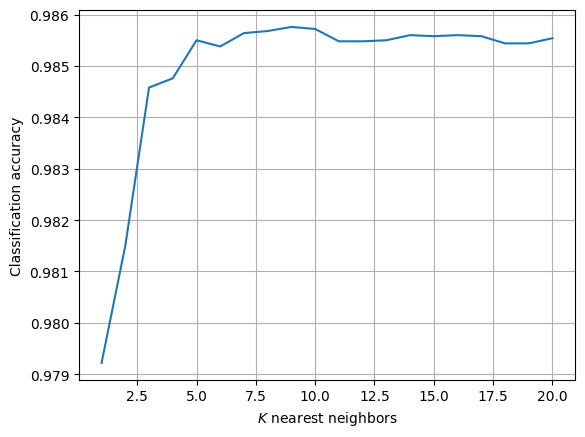

In [17]:
print("max score is for k={:d}".format(kvals[np.argmax(scores)]))
# Plot number of neighbors vs score
u = np.arange(len(scores))+1
plt.plot(u,scores)
plt.xlabel('$K$ nearest neighbors')
plt.ylabel('Classification accuracy')
plt.grid()
plt.show()

In [57]:
from sklearn.naive_bayes import GaussianNB
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

completeness [0.92743764 0.92403628 0.91666667 0.91609977]
contamination [0.06300115 0.1029169  0.10465116 0.11159978]


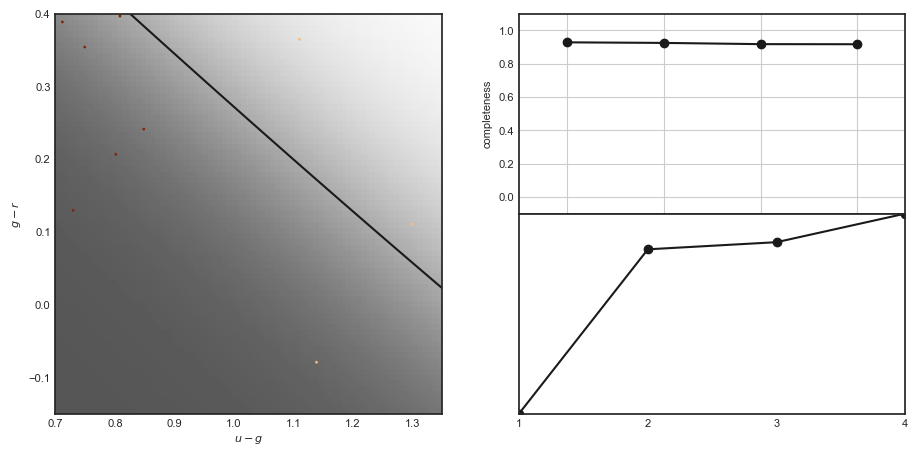

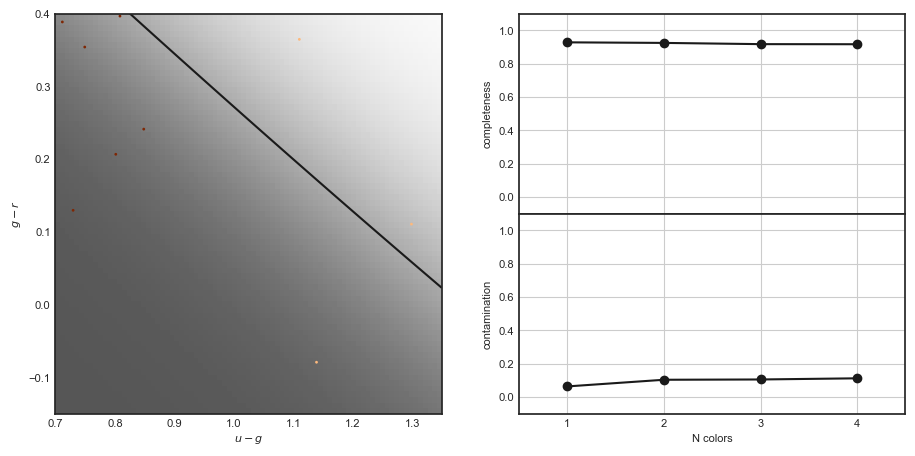

In [59]:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25],
                                                     random_state=0)

N_tot = len(y)
N_st = np.sum(y == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

#----------------------------------------------------------------------
# perform Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

order = np.array([1, 0, 2, 3])

y_prob = np.array([])

for nc in Ncolors:
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    y_pred = clf.predict(X_test[:, :nc])
    
    # Added by GTR to be able to compute precision, recall, fpr, and tpr
    # Gives the probability for both classes, take just one
    y_prob = np.append(y_prob,clf.predict_proba(X_test[:, :nc])[:,1])

    classifiers.append(clf)
    predictions.append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

# Plot completeness vs Ncolors
ax = plt.subplot(222)
ax.plot(Ncolors, completeness, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# Plot contamination vs Ncolors
ax = plt.subplot(224)
ax.plot(Ncolors, contamination, 'o-k', ms=6)

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))

ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

In [28]:
from astroML.utils import split_samples
from astroML.utils import completeness_contamination

(X_train, X_test), (y_train, y_test) = split_samples(X, true_labels, [0.75, 0.25], random_state=42)

N_tot = len(true_labels)
N_st = np.sum(true_labels == 0)
N_rr = N_tot - N_st
N_train = len(y_train)
N_test = len(y_test)
N_plot = 5000 + N_rr

In [29]:
#----------------------------------------------------------------------
# perform Classification

classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)
kvals = [1, 8]

for k in kvals:
    classifiers.append([])
    predictions.append([])
    for nc in Ncolors:
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(X_train[:, :nc], y_train)
        y_pred = clf.predict(X_test[:, :nc])

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

completeness, contamination = completeness_contamination(predictions, y_test)

print("completeness", completeness)
print("contamination", contamination)

completeness [[0.67388826 0.73888255 0.81755986 0.93842645]
 [0.70353478 0.76054732 0.82041049 0.93671608]]
contamination [[0.32879046 0.25474411 0.18244014 0.06953081]
 [0.15710383 0.12981083 0.09496855 0.03861908]]


In [30]:
#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1][1]
xlim = (0.7, 1.35)
ylim = (-0.15, 0.4)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))

Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

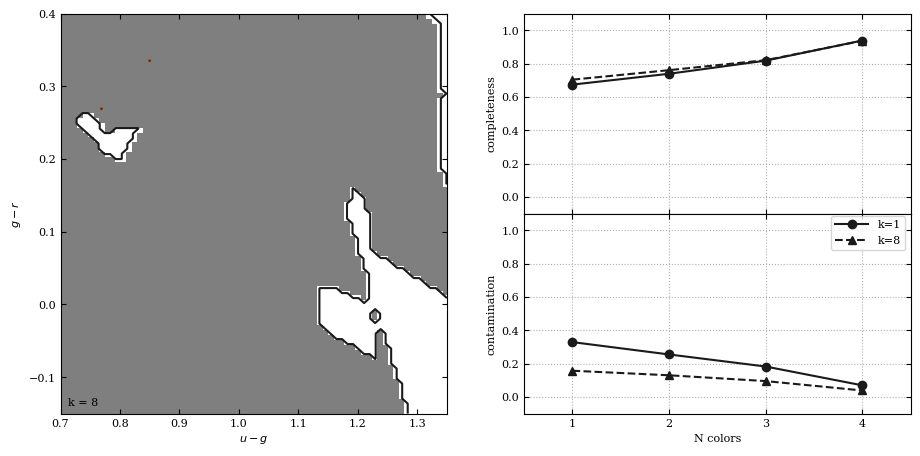

In [ ]:
# plot the results
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=true_labels[-N_plot:],
                s=4, lw=0, cmap=plt.cm.Oranges, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 2)

ax.contour(xx, yy, Z, [0.1], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel('$u-g$')
ax.set_ylabel('$g-r$')

ax.text(0.02, 0.02, "k = %i" % kvals[1],
        transform=ax.transAxes)

# plot completeness vs Ncolors
ax = fig.add_subplot(222)

ax.plot(Ncolors, completeness[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('completeness')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# plot contamination vs Ncolors
ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k', ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.legend(loc='lower right',
          bbox_to_anchor=(1.0, 0.79))

ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatXtrFormatter('%i'))
ax.set_xlabel('N colors')
ax.set_ylabel('contamination')
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()